Arrhenius benchmark from Moresi and Solomatov 1998
=======

Stagnant lid convection model
------

**This example covers the concepts of:**
1. changing rheologies, specifically temperature dependent viscosity function
2. Stokes solver options
3. saving and loading FE variables

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. Louis Moresi and Viatcheslav Solomatov, Mantle convection with a brittle lithosphere: thoughts on the global tectonic styles of the Earth and Venus. Geophys. J. Int. (1998) 133 (3): 669-682.  
http://gji.oxfordjournals.org/content/133/3/669.short


Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import time

Import ``numpy`` and ``matplotlib`` for simple plotting. The first command below is a ``python magic`` which flags to ``matplotlib`` to output any plots to the screen, specifically to the ipython notebook output cell.

In [2]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import numpy as np

Setup parameters
-----


In [3]:
dim = 2
boxLength = 1.0
boxHeight = 1.0
tempMin = 0.0
tempMax = 1.0
# set the resolution
res = 32
# Set the Rayleigh number
Ra=1.e6

**Input/output paths**

Set input and output file directory paths. For this example the input directory contains near steady state snapshots of the velocity, pressure and temperature fields. It also constains a summary of the Nusselt and $v_{RMS}$ values against time from the simulation used to make these snapshots.

In [4]:
inputPath  = 'ArrInput/'
outputPath = 'ArrOutput/'

Create mesh and finite element variables
------

In this case the mesh type used is different. For more information on the different mesh types see the user guide **HowToMesh**.

In [5]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight) )
velocityMesh    = elementMesh
temperatureMesh = elementMesh
pressureMesh    = elementMesh.subMesh 

velocityField    = uw.fevariable.FeVariable( feMesh=velocityMesh,    nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=pressureMesh,    nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial and boundary conditions**

Either set by perturbation function or load data from file.

In [6]:
LoadFromFile = True

**If loading from file**

Read 32\*32 resolution data for $P$, $v$ and $T$ fields as well as existing summary statistics data. These are converted into lists so that the main time loop below will append with new values.


In [7]:
if(LoadFromFile == True):
# set up mesh for 32*32 data file
    elementMesh32 = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                               elementRes = (32, 32), 
                                                 minCoord = (0., 0.), 
                                                 maxCoord = (boxLength, boxHeight)  )
    linearMesh32   = elementMesh32
    constantMesh32 = elementMesh32.subMesh 
    temperatureField32 = uw.fevariable.FeVariable( feMesh=linearMesh32,   nodeDofCount=1 )
    pressureField32    = uw.fevariable.FeVariable( feMesh=constantMesh32, nodeDofCount=1 )
    velocityField32    = uw.fevariable.FeVariable( feMesh=linearMesh32,   nodeDofCount=dim )

    temperatureField32.load(inputPath+'Arrhenius_32_T.inp')
    velocityField32.load(inputPath+'Arrhenius_32_v.inp')
    pressureField32.load(inputPath+'Arrhenius_32_P.inp')
    
    if(res==32): # no remeshing needed, copy directly
        temperatureField = temperatureField32
        pressureField = pressureField32
        velocityField = velocityField32
    else: # remeshing needed
        temperatureField.data[:] = temperatureField32.evaluate(linearMesh)
        pressureField.data[:] = pressureField32.evaluate(constantMesh)
        velocityField.data[:] = velocityField32.evaluate(linearMesh)
    # load summary statistics into arrays
    data = np.loadtxt(inputPath+'ArrSumary.txt', unpack=True )
    timeVal, vrmsVal, nuVal = data[0].tolist(), data[1].tolist(), data[2].tolist()
    

**If _not_ loading from file: Initialise data**

Start with a perturbed temperature gradient to speed up the convergence to the benchmark steady state solution.

In [8]:
if(LoadFromFile == False):
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.
    temperatureField.data[:] = 0.
    pertStrength = 0.1
    deltaTemp = tempMax - tempMin
    for index, coord in enumerate(temperatureMesh.data):
        pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
        temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
        temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))
# initialise summary statistics arrays
    timeVal = []
    vrmsVal = []
    nuVal = []

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [9]:
for index in temperatureMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in temperatureMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [10]:
iWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
jWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               nodeIndexSets = (allWalls,jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               nodeIndexSets = (jWalls,) )

**Plot initial conditions**

Automatically scale the size of the vector arrows for the velocity field maximum.

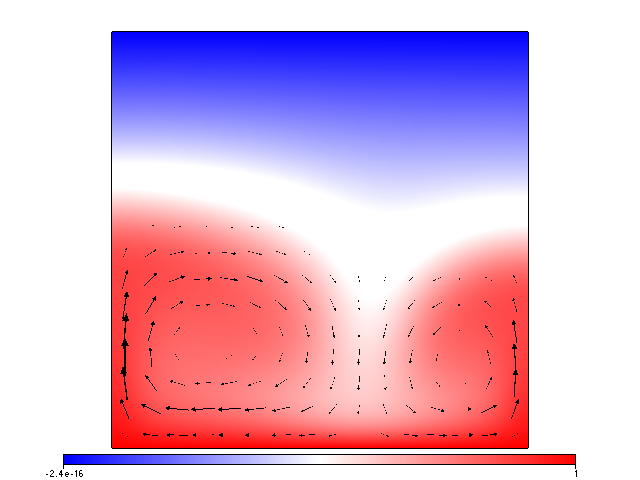

In [11]:
velmax = np.amax(velocityField.data[:])
if(velmax==0.0): velmax = 1.0
figtemp = plt.Figure()
tempminmax = fn.view.min_max(temperatureField)
figtemp.Surface(tempminmax, temperatureMesh, colours="blue white red")
figtemp.VectorArrows(velocityField, temperatureMesh, lengthScale=0.1/velmax, arrowHeadSize=0.2 )
figtemp.show()

Set up material parameters and functions
-----

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

Notes:
1. temperature must be in the range 0-1 for use with the denisity function defined using the Rayleigh number
2. viscosityFn must be a function of something for the Stokes system below.
3. this can either be done by making it explicitly a function of an existing FEVariable; e.g. of temperatureField
4. OR a function of a fn class object; e.g. of fn.misc.constant(1.0)
5. OR defined viscosityFn as a FEvariable itself

In [12]:
# Rheology
eta0 = 1.0e-6
activationEnergy = 27.63102112
Ra = 1.e6
viscosityFn = eta0 * fn.math.exp( activationEnergy / (temperatureField+1.) )

densityFn = Ra*temperatureField
# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )
# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = z_hat*densityFn


**Plot the viscosity**


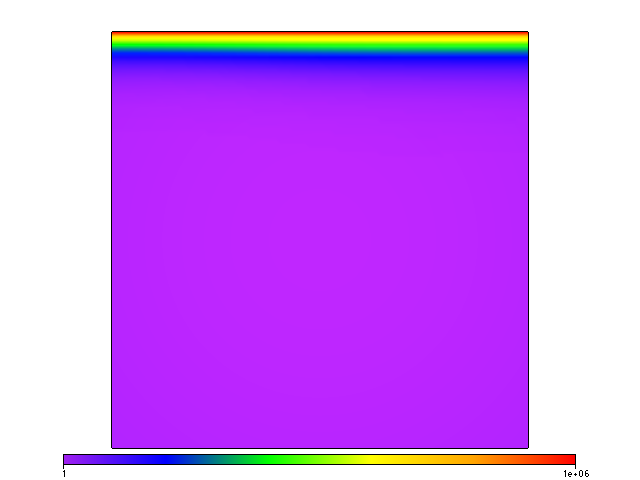

In [13]:
figEta = plt.Figure()
figEta.Surface(viscosityFn, temperatureMesh)
figEta.show()

System setup
-----

**Setup a Stokes system: advanced solver settings**

Set up parameters for the Stokes system solver. For PIC style integration, we include a swarm for the a PIC integration swarm is generated within. For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.

In [14]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn), 
                              bodyForceFn=buoyancyFn )

solver=uw.systems.Solver(stokesPIC)

solver.options.main.Q22_pc_type='uw'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-3
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

stokesPIC.solve = solver.solve

We can check what settings and defaults are currently set

In [15]:
print "## Solver Config"
print solver.options.main.list()
print "### A11 Config"
print solver.options.A11.list()

## Solver Config
('remove_constant_pressure_null_space', False)
('ksp_k2_type', 'GMG')
('change_backsolve', False)
('penalty', 1.0)
('pc_type', 'none')
('force_correction', True)
('k_scale_only', True)
('Q22_pc_type', 'uw')
('change_A11rhspresolve', False)
('ksp_type', 'bsscr')
('rescale_equations', False)
('restore_K', True)
None
### A11 Config
('ksp_type', 'fgmres')
('ksp_rtol', 0.0001)
None


**Create an advective diffusive system**


In [16]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )

Analysis tools
-----

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [17]:
v2sum_integral  = uw.utils.Integral( feMesh=velocityMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( feMesh=velocityMesh, fn=1. )

**Nusselt number**


In [18]:
def FindNusseltNumber(temperatureField, linearMesh, xmax, zmax):
    tempgradField = temperatureField.gradientFn
    vertGradField = tempgradField[1]
    BottomInt = 0.0
    GradValues = temperatureField.gradientFn[1].evaluate(temperatureMesh.specialSets["MaxJ_VertexSet"])
    TopInt = sum(GradValues)
    for index in temperatureMesh.specialSets["MinJ_VertexSet"]:
        BottomInt += temperatureField.data[index]
    Nu = -zmax*TopInt/BottomInt
    return Nu[0]

Main simulation loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Since this may be a continuation of the saved data with associated summary statistics then check if there are existing time values first. If there is existing data then add new simulation statistics after the existing data.

In [19]:
# Stepping. Initialise time and timestep.
steps_prev = len(timeVal)
steps = 0
steps_end = 100
step_out = 25

# set time to zero, unless we are loading from file
try:
    time_start = timeVal[-1]
except:
    time_start = 0.0
print 'Begining at t = ',time_start,' after having completed ',steps_prev,' steps'

simtime = time_start


Begining at t =  0.0388546520796  after having completed  1000  steps


In [20]:
# used for CPU timing
start = time.clock()

# Perform steps_end steps
rms_v, nu_no = 0.0, 0.0
while steps<steps_end:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if steps == 0:
        dt = 0.
    # Advect using this timestep siz    
    advDiff.integrate(dt)
    
    # Calculate the RMS velocity
    rms_v = math.sqrt(v2sum_integral.integrate()[0]/volume_integral.integrate()[0])
    # comment out surface integral as they are disabled 22/09/2015
    nu_no = FindNusseltNumber(temperatureField, temperatureMesh, boxLength, boxHeight)
    
    # Increment time and store results
    simtime += dt
    steps += 1
    vrmsVal.append( rms_v )
    timeVal.append( simtime )
    nuVal.append(nu_no)
                   
    if steps ==0 or steps % step_out == 0:
        print "steps = {:04d}; time = {:.6e}; vrms = {:6.2f}; nusselt = {:6.4f}; CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)
        
v2sum = v2sum_integral.integrate()
rms_v = rms_v = math.sqrt(v2sum_integral.integrate()[0]/volume_integral.integrate()[0])
# nu_no = -surface_Tgradient.integrate()[0] / basalT.integrate()[0]
nu_no = FindNusseltNumber(temperatureField, temperatureMesh, boxLength, boxHeight)

print "steps = {:04d}; time = {:.6e}; vrms = {:6.2f}; nusselt = {:6.4f}; CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)


steps = 0025; time = 3.955904e-02; vrms =  36.00; nusselt = 1.0500; CPU = 17.5s
steps = 0050; time = 4.028867e-02; vrms =  36.27; nusselt = 1.0527; CPU = 34.8s
steps = 0075; time = 4.101470e-02; vrms =  36.52; nusselt = 1.0555; CPU = 51.5s
steps = 0100; time = 4.173750e-02; vrms =  36.77; nusselt = 1.0586; CPU = 67.1s
steps = 0100; time = 4.173750e-02; vrms =  36.77; nusselt = 1.0586; CPU = 67.2s


Post simulation analysis
-----

**Check CPU timing**

Output timing for calculation per simulation time step

In [21]:
if(steps!=steps_prev):
    avtime = (time.clock() - start)/float(steps)
else:
    avtime = 0.0

print "Average time per timestep = ",avtime," seconds over ", steps, " steps"

Average time per timestep =  0.67239641  seconds over  100  steps


Pre-run model took about $1.74$ seconds per timestep and was run for $13000$ timesteps for $Ra = 10^6$ for a $64\times64$ grid.

**Save data to files**

Save system summary data; $v_{rms}$ and the Nusselt number against time.


In [22]:
np.savetxt( outputPath+'ArrSumary.out', np.c_[timeVal, vrmsVal, nuVal], header="Time, VRMS, Nusselt" )

Save final temperature, velocity and pressure fields.

In [23]:
temperatureField.save(outputPath+'Arrhenius_T.out')
velocityField.save(outputPath+'Arrhenius_v.out')
pressureField.save(outputPath+'Arrhenius_P.out')

**Plot temperature field with velocity vectors overlaid**

In [24]:
velmax = np.amax(velocityField.data[:])
figVT = plt.Figure()
figVT.Surface(temperatureField, linearMesh, colours="blue white red")
figVT.VectorArrows(velocityField, linearMesh, lengthScale=0.1/velmax, arrowHeadSize=0.2 )
figVT.show()

NameError: name 'linearMesh' is not defined

**Plot system summary information**

If the initial conditions were loaded up from a data file then these arrays will contain the saved data as well as results from the simulation just run.

In [ ]:
pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(timeVal, nuVal)
pyplot.ylabel('Nusselt Number')

pyplot.subplot(212)
pyplot.plot(timeVal,vrmsVal)
pyplot.xlabel('Time')
pyplot.ylabel('Vrms')
pyplot.show()
